In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import RobustScaler


In [52]:
def plot_signal_and_channels(signal, chans, zero=0, delta=5000):
    plt.figure(figsize=(20, 5))

    plt.subplot(2, 1, 1)
    plt.plot(signal[zero:zero+delta], label='Original Signal', color='blue')
    plt.title('Original Signal')
    plt.legend()

    plt.subplot(2, 1, 2) #data.index
    plt.plot(chans[zero:zero+delta], label='Channels', color='orange')
    plt.title('Channels')
    plt.legend()

In [53]:
def create_sequences(data, targets, seq_length=3000, step=100):
    sequences = []
    target_sequences = []
    for i in range(0, len(data) - seq_length + 1, step):
        sequences.append(data[i:i+seq_length])
        target_sequences.append(targets[i:i+seq_length])
    return np.array(sequences), np.array(target_sequences)


In [54]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, concatenate

def build_model(input_shape=(1000, 1)):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = Conv1D(16, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling1D(2)(c1)
    c2 = Conv1D(32, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling1D(2)(c2)
    
    # Bottleneck
    c3 = Conv1D(64, 3, activation='relu', padding='same')(p2)
    
    # Decoder
    u1 = UpSampling1D(2)(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv1D(32, 3, activation='relu', padding='same')(u1)
    u2 = UpSampling1D(2)(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv1D(16, 3, activation='relu', padding='same')(u2)
    
    # Output: 3 classes (0, 1, 2 channels open)
    outputs = Conv1D(3, 1, activation='softmax')(c5)
    
    model = models.Model(inputs, outputs)

    # Corrected loss function
    def peak_aware_loss(y_true, y_pred):
        # Create weights - higher for actual channel openings
        weights = tf.where(y_true[:, :, 1:] > 0, 1.0, 1.0)  # [batch, seq, 2]
        weights = tf.concat([tf.ones_like(weights[:, :, :1]), weights], axis=-1)  # [batch, seq, 3]
        
        # Calculate base loss
        loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        
        # Apply weights
        weighted_loss = loss * tf.reduce_mean(weights, axis=-1)
        return tf.reduce_mean(weighted_loss)
    
    # Custom metrics for class-specific performance
    def class_recall(class_idx):
        def recall(y_true, y_pred):
            y_true_class = y_true[:, :, class_idx]
            y_pred_class = tf.argmax(y_pred, axis=-1) == class_idx
            y_pred_class = tf.cast(y_pred_class, tf.float32)
            
            true_positives = tf.reduce_sum(y_true_class * y_pred_class)
            possible_positives = tf.reduce_sum(y_true_class)
            
            return true_positives / (possible_positives + tf.keras.backend.epsilon())
        recall.__name__ = f'recall_class_{class_idx}'
        return recall
    
    def class_precision(class_idx):
        def precision(y_true, y_pred):
            y_true_class = y_true[:, :, class_idx]
            y_pred_class = tf.argmax(y_pred, axis=-1) == class_idx
            y_pred_class = tf.cast(y_pred_class, tf.float32)
            
            true_positives = tf.reduce_sum(y_true_class * y_pred_class)
            predicted_positives = tf.reduce_sum(y_pred_class)
            
            return true_positives / (predicted_positives + tf.keras.backend.epsilon())
        precision.__name__ = f'precision_class_{class_idx}'
        return precision
    
    # Focused metrics compilation - only what you care about
    model.compile(optimizer='adam',
                loss=peak_aware_loss,
                metrics=[
                    'accuracy',
                    # Class 0 metrics (if you want them)
                    class_recall(0), class_precision(0),
                    # The important ones - class 1 and 2
                    class_recall(1), class_precision(1),
                    class_recall(2), class_precision(2),
                ])
    
    return model
    

In [55]:
model = build_model()

import visualkeras
visualkeras.layered_view(model, legend=True, scale_xy=0.2).show()

c:\Users\egrka\AppData\Local\Programs\Python\Python311\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [56]:
st = pd.read_csv('data_extracted/1.csv', header=None, names=["time", 'signal', "chans"])

# Calculate relative features
st['signal_diff'] = st['signal'].diff().fillna(0)
st['signal_rolling_mean'] = st['signal'].rolling(window=50, center=True).mean().bfill().ffill()
st['signal_relative'] = st['signal'] - st['signal_rolling_mean']
st['signal_zscore'] = (st['signal'] - st['signal_rolling_mean']) / st['signal'].rolling(window=50, center=True).std().bfill().ffill()

# X = st[["signal_relative", "signal_zscore"]].values
X = st[['signal']].values
y = st["chans"].values

scaler = RobustScaler()
X = scaler.fit_transform(X)

In [57]:
seq_len = 3000
X_seq, y_seq = create_sequences(X, y, seq_length=seq_len)

y_seq_categorical = tf.keras.utils.to_categorical(y_seq, num_classes=3)  # Assuming max 2 channels

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq_categorical, test_size=0.2, random_state=42)

# Print shapes to verify
print(f"Training data shape: {X_train.shape}")
print(f"Training targets shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test targets shape: {y_test.shape}")

Training data shape: (1016, 3000, 1)
Training targets shape: (1016, 3000, 3)
Test data shape: (254, 3000, 1)
Test targets shape: (254, 3000, 3)


In [58]:
model = build_model(input_shape=(seq_len, X_seq.shape[2]))
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 3000, 1)]            0         []                            
                                                                                                  
 conv1d_42 (Conv1D)          (None, 3000, 16)             64        ['input_8[0][0]']             
                                                                                                  
 max_pooling1d_14 (MaxPooli  (None, 1500, 16)             0         ['conv1d_42[0][0]']           
 ng1D)                                                                                            
                                                                                                  
 conv1d_43 (Conv1D)          (None, 1500, 32)             1568      ['max_pooling1d_14[0][0]

In [59]:
history = model.fit(X_train, y_train,
                   epochs=20,
                   batch_size=32,
                   validation_data=(X_test, y_test),
                   callbacks=[
                       tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
                   ])

Epoch 1/20
32/32 [==============================] - 19s 132ms/step - loss: 0.5521 - accuracy: 0.9760 - recall_class_0: 0.9853 - precision_class_0: 0.9906 - recall_class_1: 0.0000e+00 - precision_class_1: 0.0000e+00 - recall_class_2: 0.0000e+00 - precision_class_2: 0.0000e+00 - val_loss: 0.1328 - val_accuracy: 0.9912 - val_recall_class_0: 1.0000 - val_precision_class_0: 0.9912 - val_recall_class_1: 0.0000e+00 - val_precision_class_1: 0.0000e+00 - val_recall_class_2: 0.0000e+00 - val_precision_class_2: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 4s 115ms/step - loss: 0.0441 - accuracy: 0.9958 - recall_class_0: 0.9988 - precision_class_0: 0.9971 - recall_class_1: 0.6840 - precision_class_1: 0.7661 - recall_class_2: 0.0000e+00 - precision_class_2: 0.0000e+00 - val_loss: 0.0161 - val_accuracy: 0.9971 - val_recall_class_0: 0.9981 - val_precision_class_0: 0.9991 - val_recall_class_1: 0.8985 - val_precision_class_1: 0.7935 - val_recall_class_2: 0.0000e+00 - val_precision_cla

33/33 [==============================] - 57s 2s/step - loss: 0.2094 - accuracy: 0.9490 - val_loss: 1.0982 - val_accuracy: 0.4959
Epoch 2/20
33/33 [==============================] - 60s 2s/step - loss: 0.0277 - accuracy: 0.9948 - val_loss: 0.0918 - val_accuracy: 0.9883
Epoch 3/20
33/33 [==============================] - 63s 2s/step - loss: 0.0179 - accuracy: 0.9955 - val_loss: 0.0763 - val_accuracy: 0.9934
Epoch 4/20
33/33 [==============================] - 59s 2s/step - loss: 0.0161 - accuracy: 0.9956 - val_loss: 0.1116 - val_accuracy: 0.9934
Epoch 5/20
33/33 [==============================] - 59s 2s/step - loss: 0.0149 - accuracy: 0.9957 - val_loss: 0.1260 - val_accuracy: 0.9934
Epoch 6/20
33/33 [==============================] - 59s 2s/step - loss: 0.0136 - accuracy: 0.9961 - val_loss: 0.1416 - val_accuracy: 0.9934

In [60]:
# Prediction function
def predict_channels(signal_sequence, model, scaler, rolling_window=50):
    df = pd.DataFrame({'signal': signal_sequence})
    df['signal_rolling_mean'] = df['signal'].rolling(window=rolling_window, center=True).mean().bfill().ffill()
    df['signal_relative'] = df['signal'] - df['signal_rolling_mean']
    df['signal_zscore'] = (df['signal'] - df['signal_rolling_mean']) / df['signal'].rolling(window=rolling_window, center=True).std().bfill().ffill()
    
    # X_new = scaler.transform(df[["signal_relative", "signal_zscore"]].values)
    X_new = scaler.transform(df[["signal"]].values)
    X_new_seq = np.expand_dims(X_new, axis=0)
    
    preds = model.predict(X_new_seq)[0]
    channel_counts = np.argmax(preds, axis=1)
    
    return channel_counts

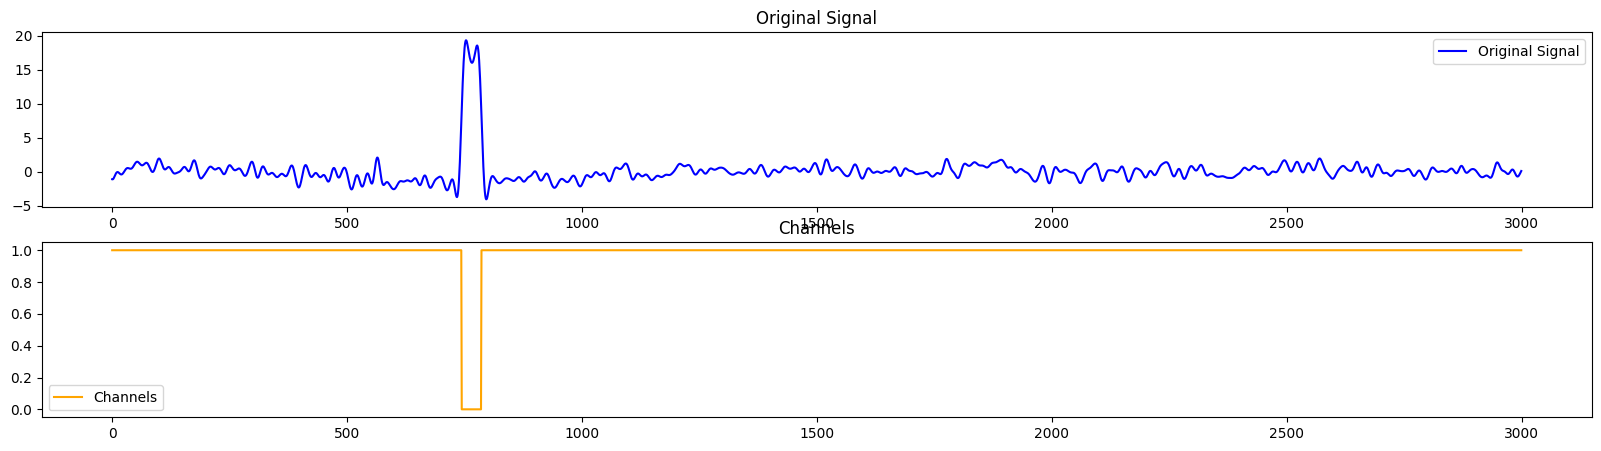

In [61]:
p = 5

probe = X_train[p]
y_probe = y_train[p]
plot_signal_and_channels(probe[:, 0], y_probe[:, 0])

In [62]:
def plot_signal_and_channels_and_truth(signal, chans, truth, zero=0, delta=5000):
    plt.figure(figsize=(20, 5))

    plt.subplot(3, 1, 1)
    plt.plot(signal[zero:zero+delta], label='Original Signal', color='blue')
    plt.title('Original Signal')
    plt.legend()

    plt.subplot(3, 1, 2) #data.index
    plt.plot(chans[zero:zero+delta], label='Channels', color='orange')
    plt.title('Channels')
    plt.legend()

    plt.subplot(3, 1, 3) #data.index
    plt.plot(truth[zero:zero+delta], label='Truth', color='green')
    plt.title('Truth')
    plt.legend()

1/1 [==============================] - 0s 16ms/step


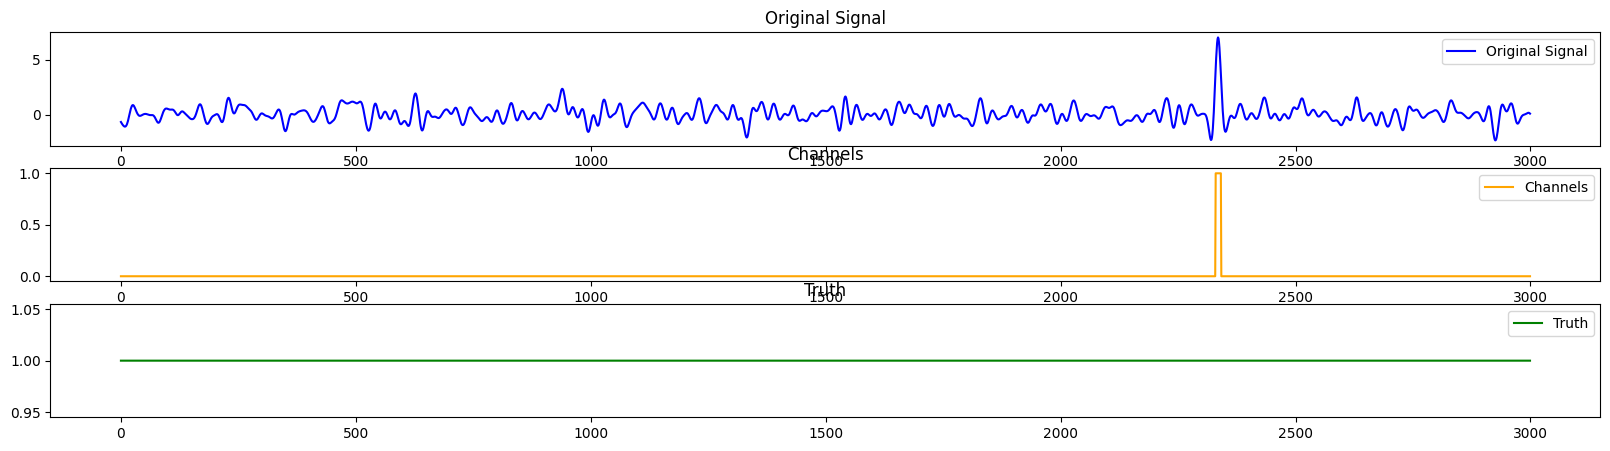

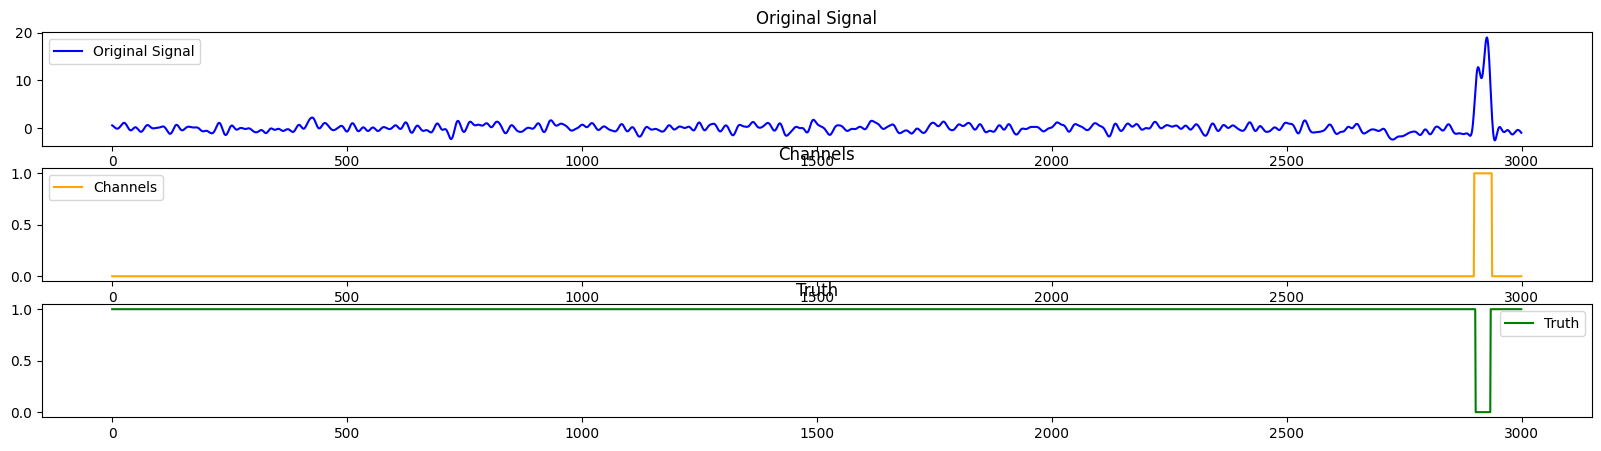

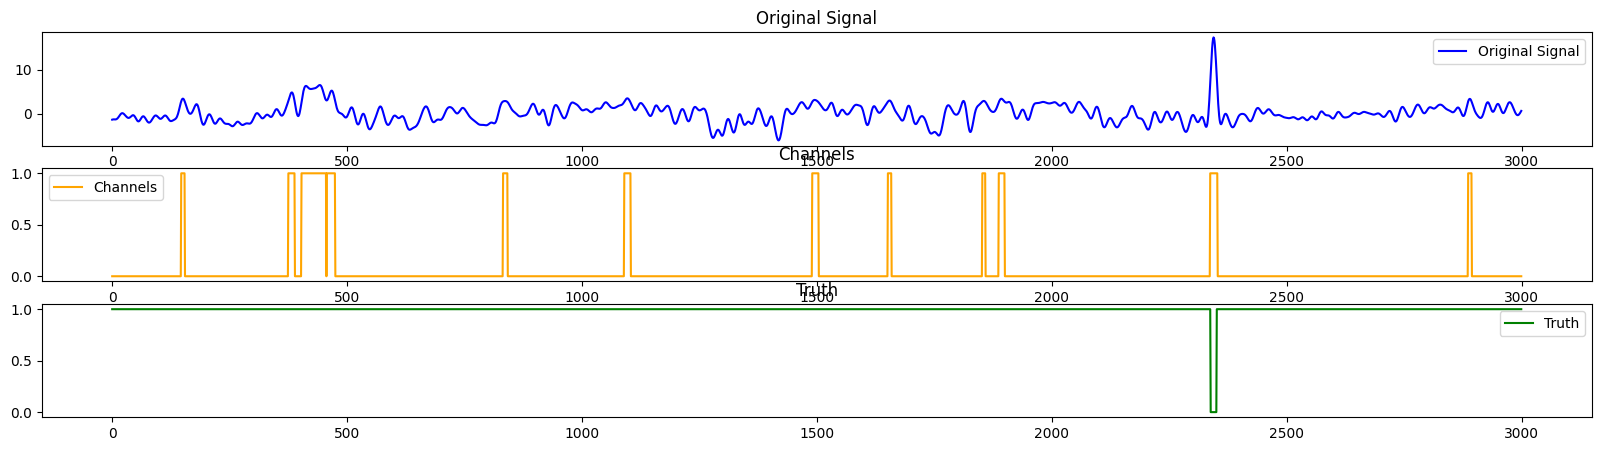

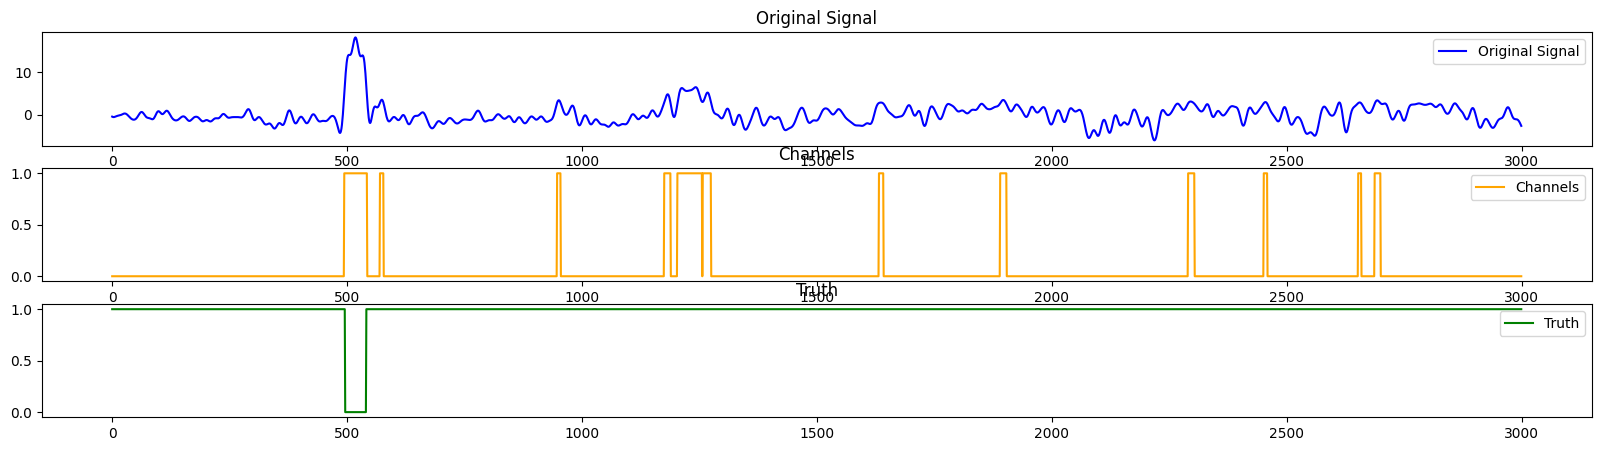

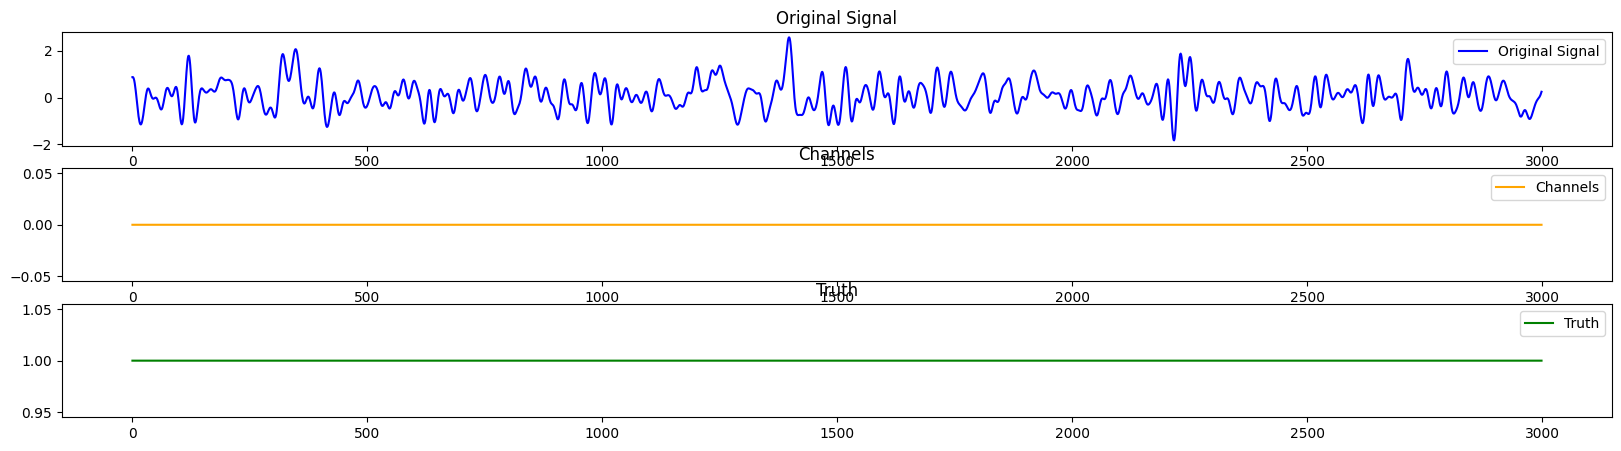

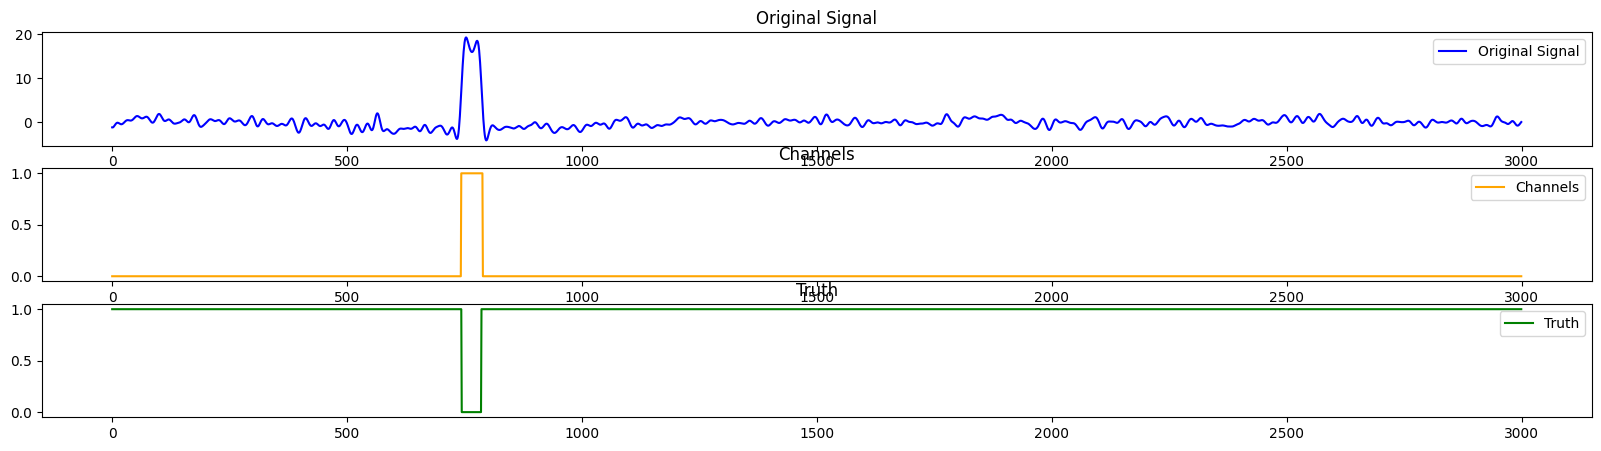

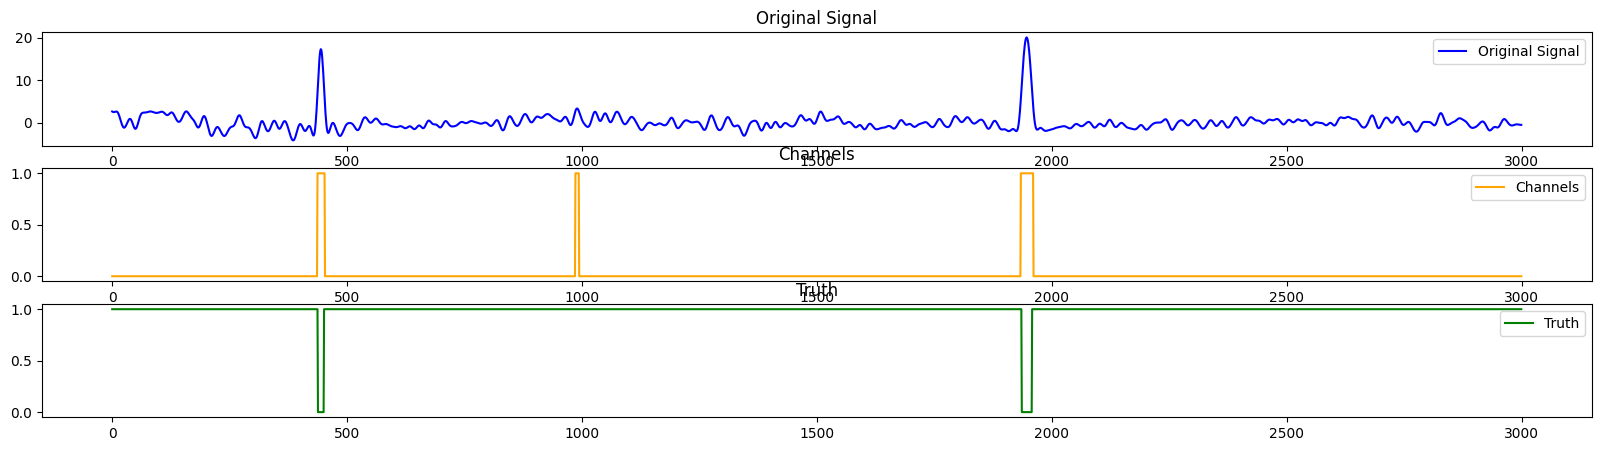

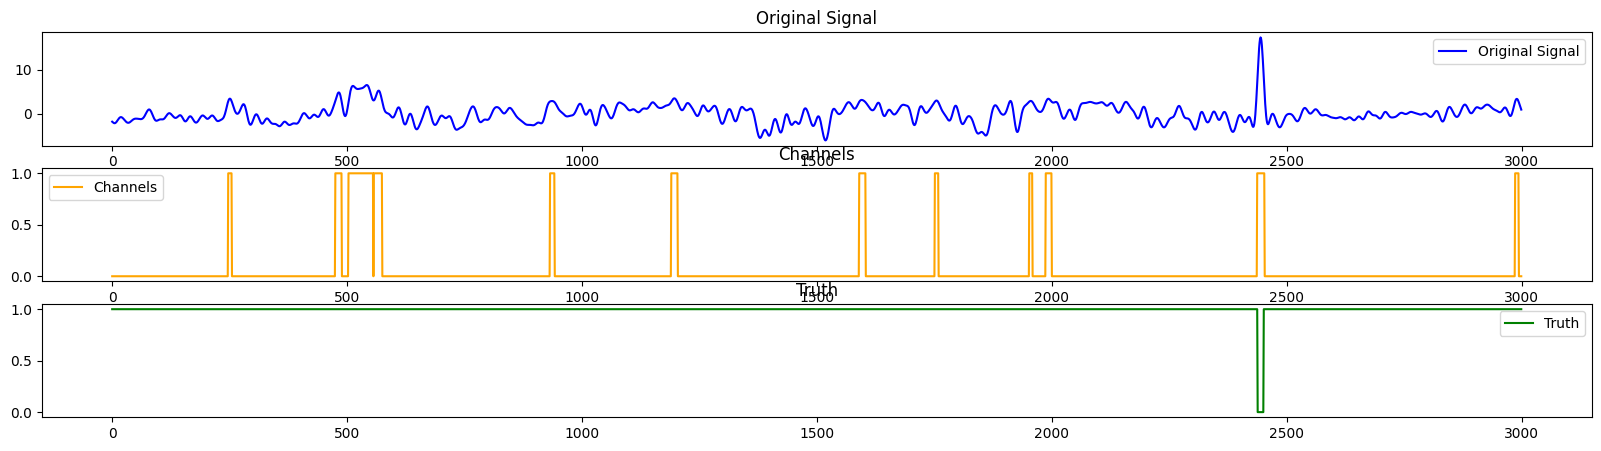

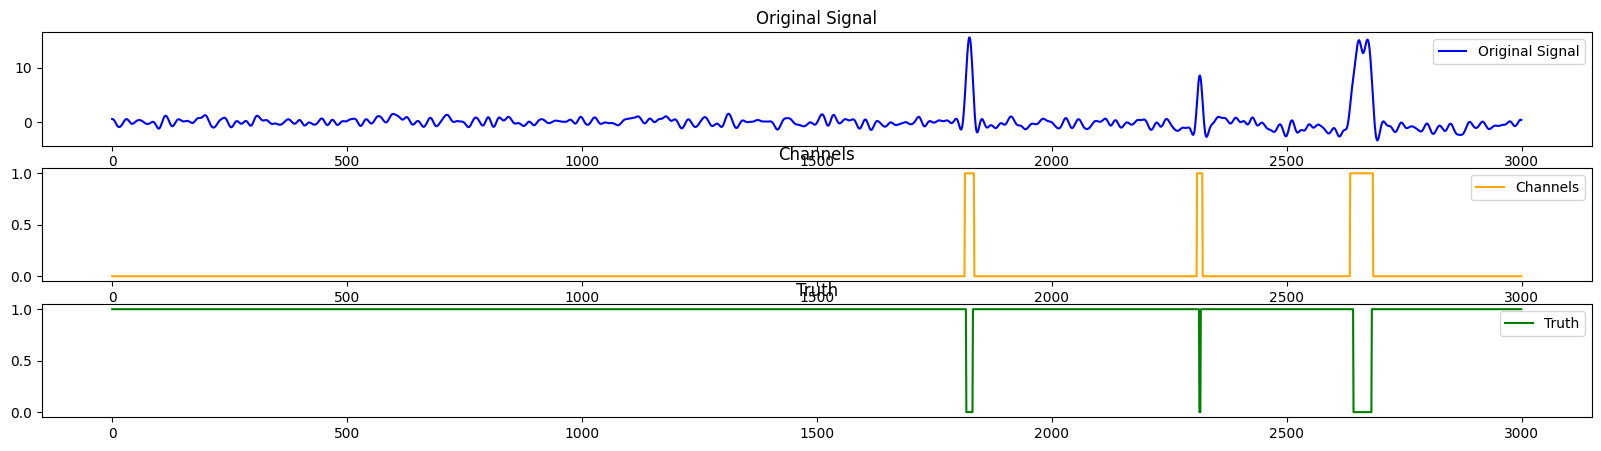

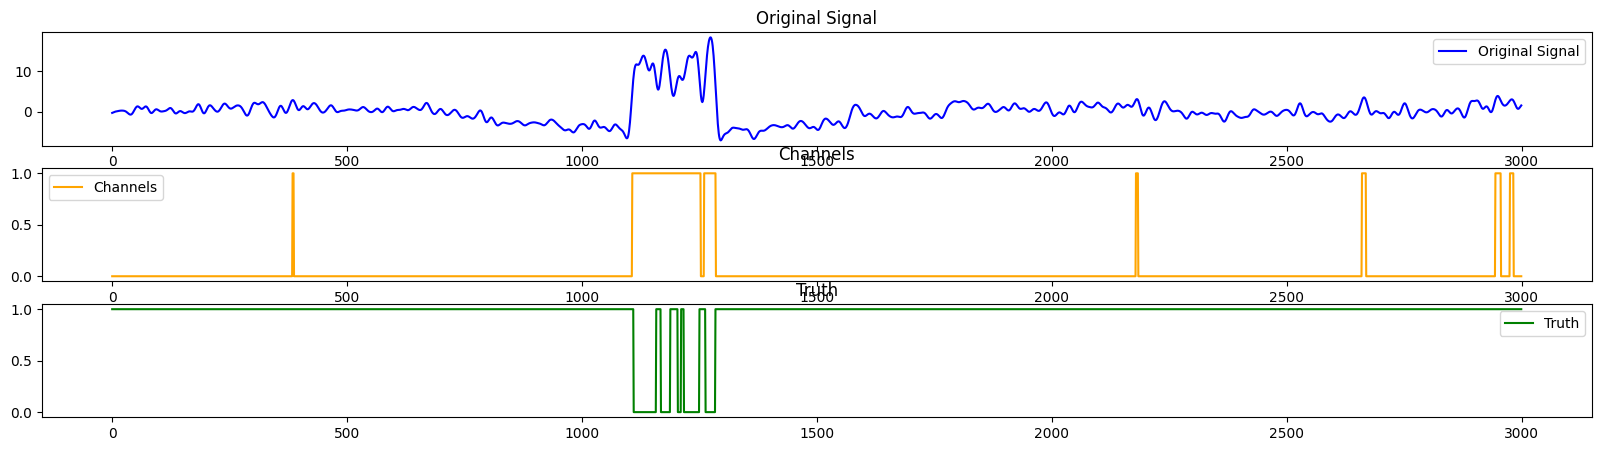

In [63]:
for i in range(10):
    # Test
    test_signal = X_train[i][:, 0]
    predicted_channels = predict_channels(test_signal, model, scaler)

    plot_signal_and_channels_and_truth(test_signal, predicted_channels, y_train[i][:, 0])
    # plot_signal_and_channels(test_signal, y_train[i][:, 0])